In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import SequentialSampler

import monai
from monai.losses import FocalLoss
from monai.data import DataLoader, CacheDataset
from monai.transforms import (EnsureChannelFirstd, Compose, Resized, ScaleIntensityRanged, LoadImaged)

In [2]:
# Check environment
print(torch.__version__)
print(torch.version.cuda)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

2.7.0+cu128
12.8
Using cuda device


### Prerequisites

In [3]:
def extract_patient_id(file_path):
    filename = os.path.basename(file_path)
    main_part = filename.split('.')[0]
    desired_part = main_part.split('-')[0]
    return desired_part.lower()


def labels_to_numeric(labels_df):
    label_cols = [
        'fracture_classification',
        'gt_displacement_greater_equal_to_1cm',
        'shaft_translation',
        'varus_malalignment',
        'art_involvement'
    ]
    labels_df = labels_df.loc[:, ['patient_id'] + label_cols]

    encoders = {}
    for col in label_cols:
        le = LabelEncoder().fit(labels_df[col])
        labels_df[col] = le.transform(labels_df[col])
        encoders[col] = le
    return labels_df, encoders


def sort_labels(images, df):

    label_map = {}
    for _, row in df.iterrows():
        pid = row["patient_id"].lower()
        label_map[pid] = {
            'fracture': row['fracture_classification'],
            'displacement': row['gt_displacement_greater_equal_to_1cm'],
            'shaft_trans': row['shaft_translation'],
            'varus': row['varus_malalignment'],
            'articular': row['art_involvement']
        }

    labels = []
    for path in images:
        pid = extract_patient_id(path)
        labels.append([
            label_map[pid]['fracture'],
            label_map[pid]['displacement'],
            label_map[pid]['shaft_trans'],
            label_map[pid]['varus'],
            label_map[pid]['articular']
        ])

    return np.array(labels)

In [4]:
def calc_metrics(outputs, labels, is_multiclass):
    metrics = {}

    if is_multiclass:
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        metrics['accuracy'] = accuracy_score(labels, preds)

        auc_scores = []
        label_bin = label_binarize(labels, classes=np.arange(probs.shape[1]))
        for i in range(probs.shape[1]):
            auc = roc_auc_score(
                label_bin[:,i],
                probs[:,i].numpy(),
                multi_class='ovr')
            auc_scores.append(auc)
        metrics['auc'] = {j: auc_scores[j] for j in range(len(auc_scores))}

        cm = confusion_matrix(labels, preds)
        n_classes = cm.shape[0]
        sensitivity_list = []
        specificity_list = []
        ppv_list = []
        npv_list = []

        for i in range(n_classes):
            tp = cm[i, i]
            fn = np.sum(cm[i, :]) - tp
            fp = np.sum(cm[:, i]) - tp
            tn = np.sum(cm) - tp - fn - fp

            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

            ppv_list.append(ppv)
            npv_list.append(npv)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)


        metrics['ppv'] = {j: ppv_list[j] for j in range(len(ppv_list))}
        metrics['npv'] = {j: npv_list[j] for j in range(len(npv_list))}
        metrics['sensitivity'] = {j: sensitivity_list[j] for j in range(len(sensitivity_list))}
        metrics['specificity'] = {j: specificity_list[j] for j in range(len(specificity_list))}

    else:
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        metrics['accuracy'] = accuracy_score(labels, preds)

        prob_class1 = probs.numpy()
        prob_class0 = 1 - prob_class1
        auc_scores = []

        auc0 = roc_auc_score(labels.numpy(), prob_class0)
        auc1 = roc_auc_score(labels.numpy(), prob_class1)
        auc_scores.append(auc0)
        auc_scores.append(auc1)
        metrics['auc'] = {j: auc_scores[j] for j in range(len(auc_scores))}

        cm = confusion_matrix(labels, preds)
        sensitivity_list = []
        specificity_list = []
        ppv_list = []
        npv_list = []

        for i in range(2):
            tp = cm[i, i]
            fn = np.sum(cm[i, :]) - tp
            fp = np.sum(cm[:, i]) - tp
            tn = np.sum(cm) - tp - fn - fp

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0

            ppv_list.append(ppv)
            npv_list.append(npv)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)

        metrics['ppv'] = {j: ppv_list[j] for j in range(len(ppv_list))}
        metrics['npv'] = {j: npv_list[j] for j in range(len(npv_list))}
        metrics['sensitivity'] = {j: sensitivity_list[j] for j in range(len(sensitivity_list))}
        metrics['specificity'] = {j: specificity_list[j] for j in range(len(specificity_list))}

    return cm, metrics

In [5]:
def validate(model, val_loader, loss_function):
    model.eval()
    total_loss = 0.0
    task_losses = defaultdict(float)
    task_dict = {
        0:'fracture',
        1:'displacement',
        2:'shaft_trans',
        3:'varus',
        4:'articular',
    }

    all_outputs = {task: [] for task in task_dict.values()}
    all_labels = {task: [] for task in task_dict.values()}

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device).long()

            outputs = model(inputs)
            loss, losses = loss_function(outputs, labels)

            total_loss += loss.item()

            for i, task_name in task_dict.items():
                all_outputs[task_name].append(outputs[i].detach().cpu())
                all_labels[task_name].append(labels[:, i].cpu())

    avg_loss = total_loss / len(val_loader)
    detailed_metrics = {}

    cms = []
    for task_name in task_dict.values():
        outputs_tensor = torch.cat(all_outputs[task_name])
        labels_tensor = torch.cat(all_labels[task_name])

        is_multiclass = task_name in ['fracture', 'shaft_trans', 'articular']

        cm, task_metrics = calc_metrics(outputs_tensor, labels_tensor, is_multiclass)
        cms.append(cm)

        task_metrics['loss'] = task_losses[task_name] / len(val_loader)

        detailed_metrics[task_name] = task_metrics

    return cms, avg_loss, detailed_metrics

In [6]:
class MultiTaskLoss(nn.Module):
    def __init__(self, weights, device="cuda"):
        super().__init__()
        self.weights = weights
        self.loss_fns = nn.ModuleList([

            FocalLoss(
                gamma=2.0,
                use_softmax=True,
                to_onehot_y=True,
                include_background=True
            ).to(device),


            FocalLoss(
                gamma=2.0,
                alpha=0.5,
                use_softmax=False,
            ).to(device),


            FocalLoss(
                gamma=2.0,
                use_softmax=True,
                to_onehot_y=True,
                include_background=True
            ).to(device),


            FocalLoss(
                gamma=2.0,
                alpha=0.5,
                use_softmax=False,
            ).to(device),


            FocalLoss(
                gamma=2.0,
                use_softmax=True,
                to_onehot_y=True,
                include_background=True
            ).to(device),
        ])

    def forward(self, outputs, targets):
        total_loss = 0
        losses = []

        for i, (fn, w) in enumerate(zip(self.loss_fns, self.weights)):
            out = outputs[i]
            tgt = targets[:, i]

            if i in [1,3]:
                out = out.unsqueeze(-1) if out.dim() == 1 else out
                tgt = tgt.float().unsqueeze(-1)
            else:
                tgt = tgt.long()

            loss = w * fn(out, tgt)
            losses.append(loss)
            total_loss += loss

        return total_loss, losses

### Load the model

In [7]:
model_best = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=1024).to(device)
model_path = "final_multi_3d_clf4.pth"
model_best.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Configuration

In [8]:
name_dict = {
    'fracture':'fracture_classification',
    'displacement':'gt_displacement_greater_equal_to_1cm',
    'shaft_trans':'shaft_translation',
    'varus':'varus_malalignment',
    'articular':'art_involvement',
}

### Internal validation

In [9]:
val_labels_df = pd.read_csv('test_labels.csv')

val_labels_df, val_encoders = labels_to_numeric(val_labels_df)
# print(val_encoders)

val_images = sorted(glob.glob("new_datasets/one_side_test/*.nii"))

val_labels = sort_labels(val_images, val_labels_df)
val_dicts = [{
    "image": img_path,
    "label": lbl
} for img_path, lbl in zip(val_images, val_labels)]

val_transforms = Compose([
    LoadImaged(keys=["image"], image_only=True),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityRanged(keys=["image"], a_min=-500, a_max=1300, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=(128, 128, 128)),
])

val_ds = CacheDataset(
    data=val_dicts,
    transform=val_transforms,
    num_workers=4
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    sampler=SequentialSampler(val_ds),
    num_workers=4
)

Loading dataset: 100%|██████████| 117/117 [00:02<00:00, 49.15it/s]


In [10]:
criterion = MultiTaskLoss(weights=[1.0, 1.0, 1.0, 1.0, 1.0])
cms, val_loss, detailed_metrics = validate(model_best, val_loader, criterion)
for task, metrics in detailed_metrics.items():
    print(f"\nTask: {task}")
    print(f"\tOverall Acc: {metrics['accuracy']:.3f}")
    for key in metrics['auc'].keys():
        print(f"\t{val_encoders[name_dict[task]].classes_[key]}\tAUC: {metrics['auc'][key]:.3f} | Sen: {metrics['sensitivity'][key]:.3f} | Spec: {metrics['specificity'][key]:.3f} | Ppv: {metrics['ppv'][key]:.3f} | Npv: {metrics['npv'][key]:.3f}")


Task: fracture
	Overall Acc: 0.786
	1-part	AUC: 0.929 | Sen: 0.643 | Spec: 0.971 | Ppv: 0.750 | Npv: 0.952
	2-part	AUC: 0.874 | Sen: 0.795 | Spec: 0.836 | Ppv: 0.745 | Npv: 0.871
	dislocation	AUC: 0.990 | Sen: 0.846 | Spec: 0.981 | Ppv: 0.846 | Npv: 0.981
	multipart	AUC: 0.933 | Sen: 0.804 | Spec: 0.887 | Ppv: 0.822 | Npv: 0.875

Task: displacement
	Overall Acc: 0.803
	no	AUC: 0.124 | Sen: 0.870 | Spec: 0.761 | Ppv: 0.702 | Npv: 0.900
	yes	AUC: 0.876 | Sen: 0.761 | Spec: 0.870 | Ppv: 0.900 | Npv: 0.702

Task: shaft_trans
	Overall Acc: 0.880
	entire	AUC: 0.938 | Sen: 0.471 | Spec: 1.000 | Ppv: 1.000 | Npv: 0.917
	none	AUC: 0.951 | Sen: 1.000 | Spec: 0.391 | Ppv: 0.870 | Npv: 1.000
	substantial	AUC: 0.707 | Sen: 0.167 | Spec: 1.000 | Ppv: 1.000 | Npv: 0.957

Task: varus
	Overall Acc: 0.872
	no	AUC: 0.088 | Sen: 0.927 | Spec: 0.743 | Ppv: 0.894 | Npv: 0.812
	yes	AUC: 0.912 | Sen: 0.743 | Spec: 0.927 | Ppv: 0.812 | Npv: 0.894

Task: articular
	Overall Acc: 0.821
	headsplit	AUC: 0.551 | Se

In [11]:
task_meta = {
    'fracture': {
        'type': 'multiclass',
        'labels': val_encoders['fracture_classification'].classes_
    },
    'displacement': {
        'type': 'binary',
        'labels': val_encoders['gt_displacement_greater_equal_to_1cm'].classes_
    },
    'shaft_trans': {
        'type': 'multiclass',
        'labels': val_encoders['shaft_translation'].classes_
    },
    'varus': {
        'type': 'binary',
        'labels': val_encoders['varus_malalignment'].classes_
    },
    'articular': {
        'type': 'multiclass',
        'labels': val_encoders['art_involvement'].classes_
    }
}

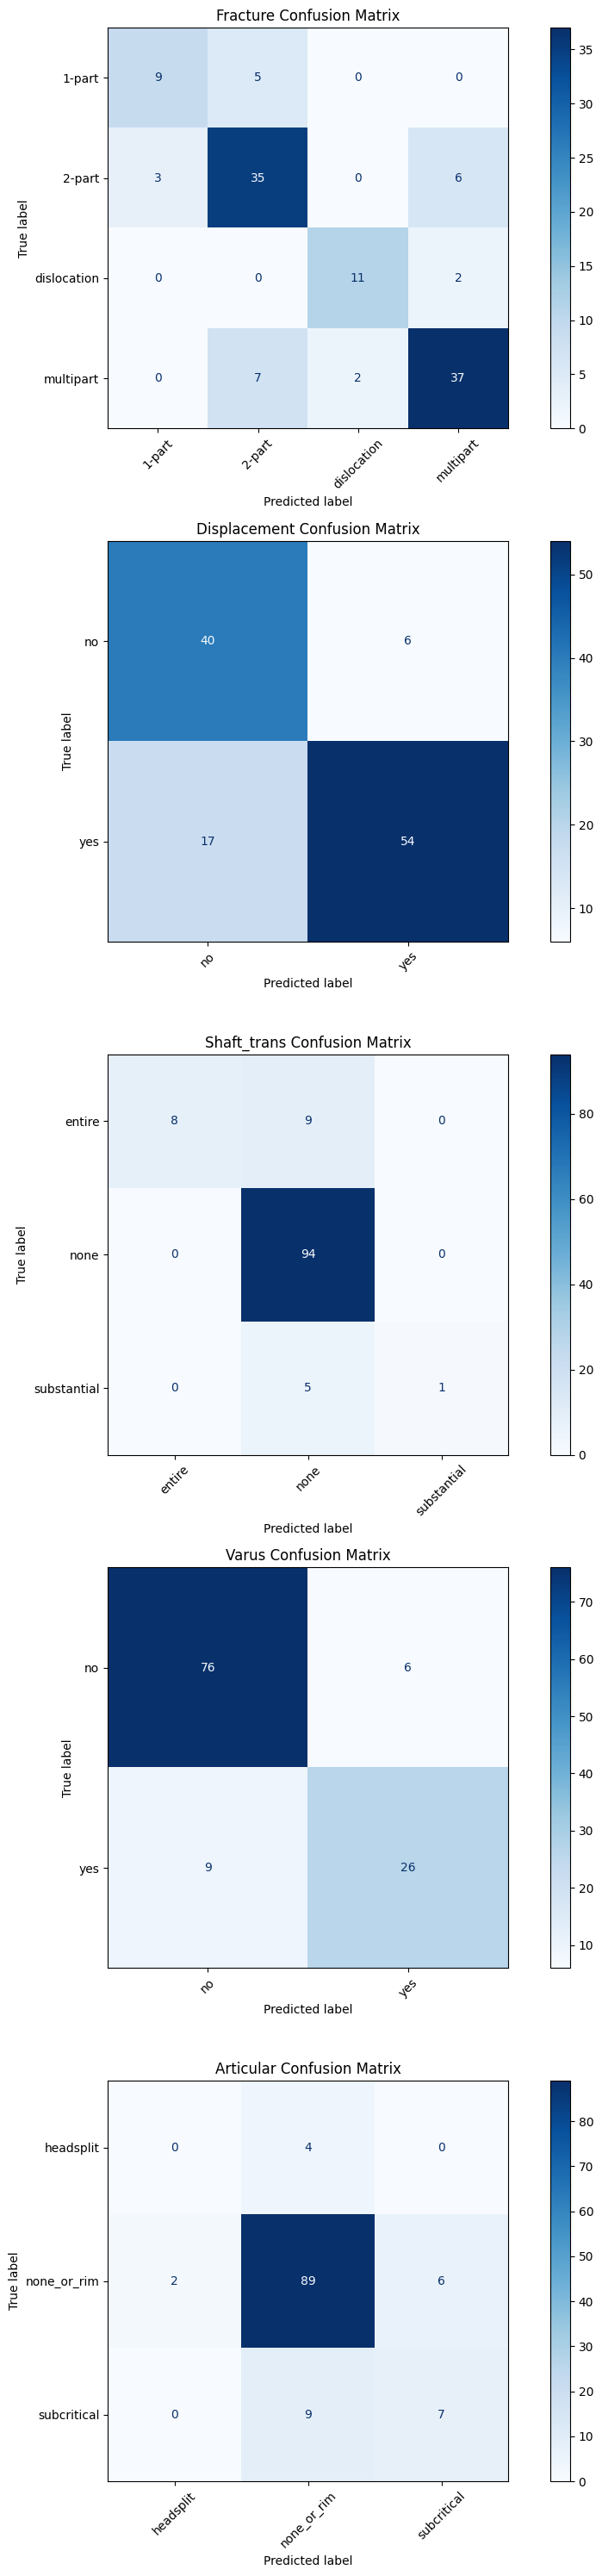

In [12]:
plt.figure(figsize=(10, 30))
for i, (task, meta) in enumerate(task_meta.items(), 1):
    plt.subplot(5, 1, i)

    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i-1],
                                 display_labels=meta['labels'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'{task.capitalize()} Confusion Matrix')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### External validation

In [13]:
ex_labels_df = pd.read_csv('ex_valid_labels.csv')

ex_labels_df, ex_encoders = labels_to_numeric(ex_labels_df)

ex_images = sorted(glob.glob("new_datasets/one_side_ex_validation/*.nii"))

ex_labels = sort_labels(ex_images, ex_labels_df)
ex_dicts = [{
    "image": img_path,
    "label": lbl
} for img_path, lbl in zip(ex_images, ex_labels)]

ex_transforms = Compose([
    LoadImaged(keys=["image"], image_only=True),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityRanged(keys=["image"], a_min=-500, a_max=1300, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=(128, 128, 128)),
])

ex_ds = CacheDataset(
    data=ex_dicts,
    transform=ex_transforms,
    num_workers=4
)

ex_loader = DataLoader(
    ex_ds,
    batch_size=4,
    sampler=SequentialSampler(ex_ds),
    num_workers=4
)

Loading dataset: 100%|██████████| 122/122 [00:04<00:00, 30.19it/s]


In [14]:
cms, val_loss, detailed_metrics = validate(model_best, ex_loader, criterion)
for task, metrics in detailed_metrics.items():
    print(f"\nTask: {task}")
    print(f"\tOverall Acc: {metrics['accuracy']:.3f}")
    for key in metrics['auc'].keys():
        print(f"\t{ex_encoders[name_dict[task]].classes_[key]}\tAUC: {metrics['auc'][key]:.3f} | Sen: {metrics['sensitivity'][key]:.3f} | Spec: {metrics['specificity'][key]:.3f} | Ppv: {metrics['ppv'][key]:.3f} | Npv: {metrics['npv'][key]:.3f}")


Task: fracture
	Overall Acc: 0.770
	1-part	AUC: 0.951 | Sen: 0.667 | Spec: 0.973 | Ppv: 0.667 | Npv: 0.973
	2-part	AUC: 0.854 | Sen: 0.826 | Spec: 0.750 | Ppv: 0.667 | Npv: 0.877
	dislocation	AUC: 0.906 | Sen: 0.833 | Spec: 1.000 | Ppv: 1.000 | Npv: 0.982
	multipart	AUC: 0.919 | Sen: 0.727 | Spec: 0.910 | Ppv: 0.870 | Npv: 0.803

Task: displacement
	Overall Acc: 0.795
	no 	AUC: 0.124 | Sen: 0.759 | Spec: 0.824 | Ppv: 0.774 | Npv: 0.812
	yes	AUC: 0.876 | Sen: 0.824 | Spec: 0.759 | Ppv: 0.812 | Npv: 0.774

Task: shaft_trans
	Overall Acc: 0.861
	entire	AUC: 0.947 | Sen: 0.632 | Spec: 0.971 | Ppv: 0.800 | Npv: 0.935
	none	AUC: 0.964 | Sen: 0.978 | Spec: 0.600 | Ppv: 0.882 | Npv: 0.900
	substantial	AUC: 0.795 | Sen: 0.273 | Spec: 0.982 | Ppv: 0.600 | Npv: 0.932

Task: varus
	Overall Acc: 0.844
	no	AUC: 0.109 | Sen: 0.880 | Spec: 0.733 | Ppv: 0.910 | Npv: 0.667
	yes	AUC: 0.891 | Sen: 0.733 | Spec: 0.880 | Ppv: 0.667 | Npv: 0.910

Task: articular
	Overall Acc: 0.861
	headsplit	AUC: 0.625 | S

In [15]:
task_meta = {
    'fracture': {
        'type': 'multiclass',
        'labels': ex_encoders['fracture_classification'].classes_
    },
    'displacement': {
        'type': 'binary',
        'labels': ex_encoders['gt_displacement_greater_equal_to_1cm'].classes_
    },
    'shaft_trans': {
        'type': 'multiclass',
        'labels': ex_encoders['shaft_translation'].classes_
    },
    'varus': {
        'type': 'binary',
        'labels': ex_encoders['varus_malalignment'].classes_
    },
    'articular': {
        'type': 'multiclass',
        'labels': ex_encoders['art_involvement'].classes_
    }
}

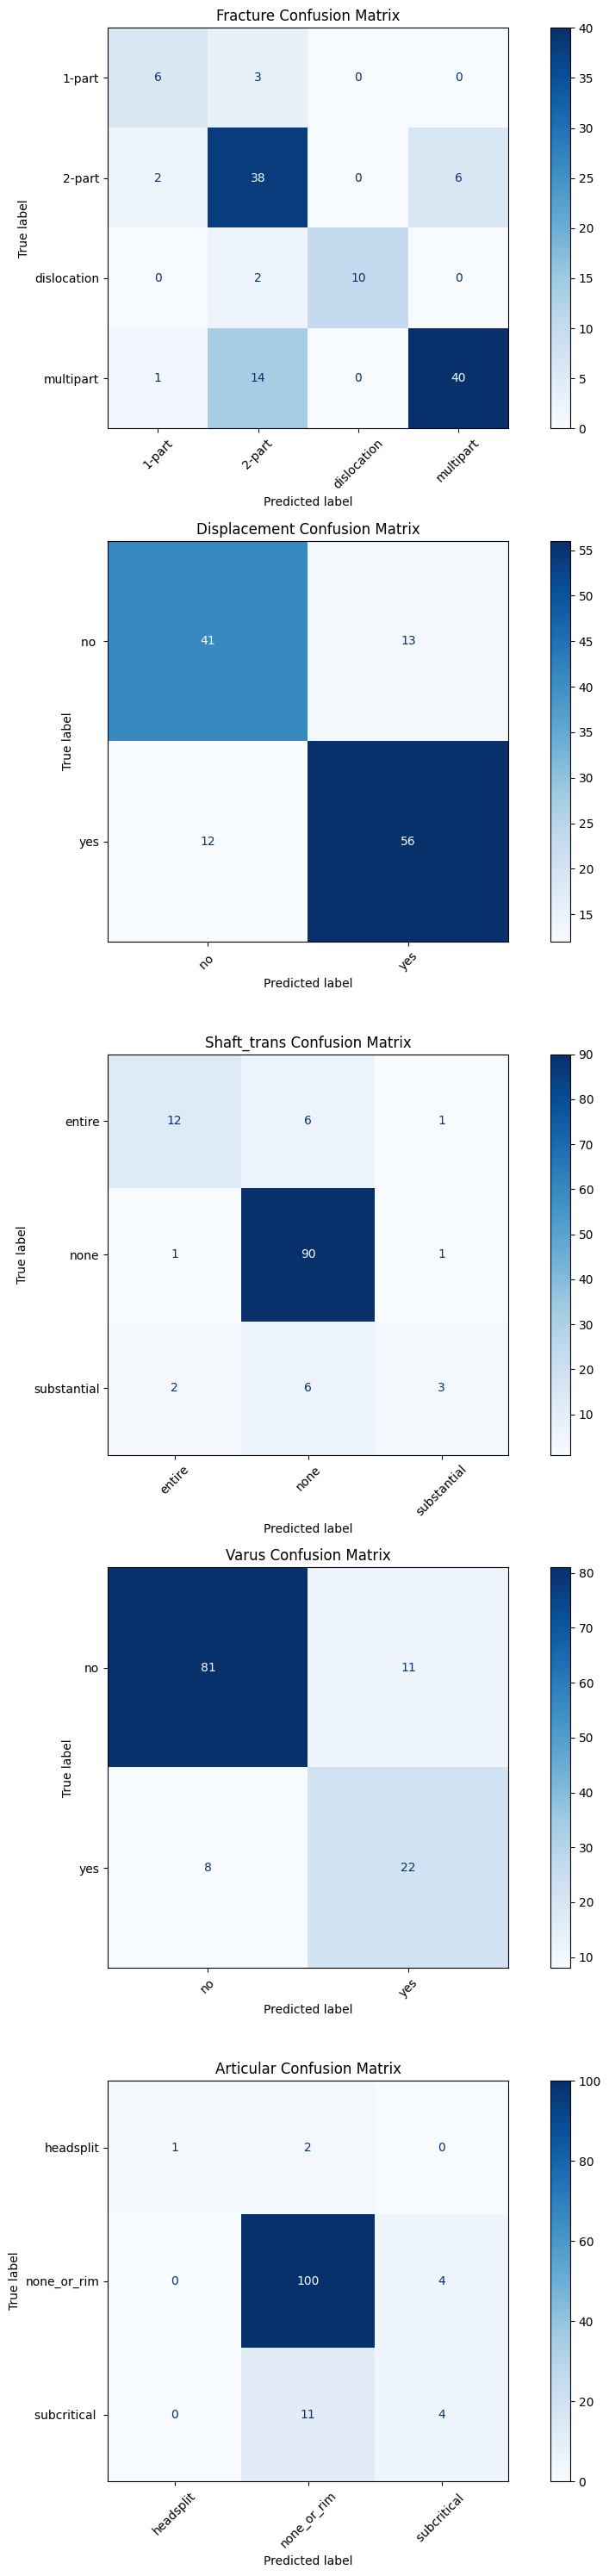

In [16]:
plt.figure(figsize=(10, 30))
for i, (task, meta) in enumerate(task_meta.items(), 1):
    plt.subplot(5, 1, i)

    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i-1],
                                 display_labels=meta['labels'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'{task.capitalize()} Confusion Matrix')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()